<a href="https://colab.research.google.com/github/yoonwanggyu/Self_Study/blob/main/%EC%98%A4%ED%94%84%EB%9D%BC%EC%9D%B8/ResNet_%EB%85%BC%EB%AC%B8_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow

## Residual Block

## 2 way of shortcut connection
- identity shortcut connection
- projected shortcut connection

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

ResNet-18,34는 왼쪽 residual block을 사용하고, ResNet-50 부터는 오른쪽 BottleNeck을 사용합니다.

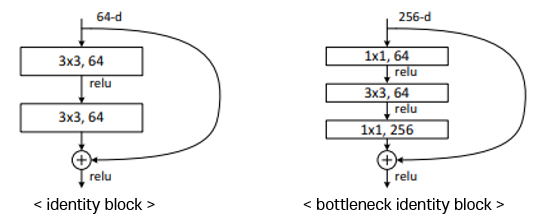

shortcut connection 시, 사용해야할 함수 : layers.Add()

In [ ]:
def conv_block(x, filters, kernel_size, strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation='linear')(x)
    x = layers.BatchNormalization()(x)
    return x

In [ ]:
def identity_block(inputs, filters, kernel_size, strides=1):
    shortcut = inputs

    # x = conv_block(inputs, filters, 3)




    # x = layers.Add()([x, shortcut])

    return x

In [ ]:
def bottleneck_identity_block(inputs, filters, kernel_size, strides=1):
    shortcut = inputs



    return x

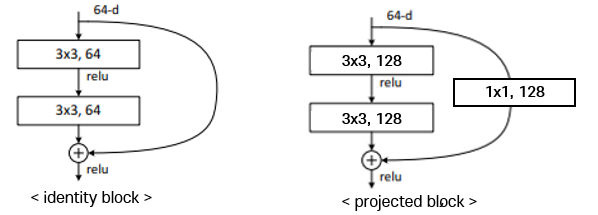

In [ ]:
def projection_block(inputs, filters, kernel_size, strides=1):
    shortcut = conv_block(inputs, filters, 1)


    return x

# Pytorch

## ResNet50 구현

Bottleneck 블록은 1x1, 3x3, 1x1 컨볼루션 레이어로 구성되어 있으며, 이를 통해 모델의 연산 효율성과 성능을 향상시킵니다.

- 1x1 컨볼루션: 채널 수를 축소하여 연산량을 줄입니다.
- 3x3 컨볼루션: 주요 특징을 추출합니다.
- 1x1 컨볼루션: 채널 수를 다시 확장합니다.

또한, 입력과 출력을 직접 연결하는 잔차 연결(residual connection)도 포함됩니다. 이 잔차 연결은 입력 데이터를 출력에 더하여 기울기 소실 문제를 완화합니다.

## Residual Block은 기본 블록과 Bottleneck 블록으로 나눌 수 있습니다.

    """
    - in_planes: in_channels
    - out_channels: out_channels
    - bias=False: BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정.
    """

Basic block

In [1]:
import torch
import torch.nn as nn

class Basicblock(nn.Module):
    expansion = 1

    def __init__(self,inplanes,planes,stride=1,downsample=None):
        super(Basicblock,self).__init__()

        self.conv1 = nn.Conv2d(inplanes,planes,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes,planes,kernel_size=3,padding=1,biase=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        # identity mapping시 identity mapping후 ReLU를 적용합니다.
        # 그 이유는, ReLU를 통과하면 양의 값만 남기 때문에 Residual의 의미가 제대로 유지되지 않기 때문입니다.
        out += identity
        out = self.relu(out)

        return out

BottleNeck

In [2]:
import torch
import torch.nn as nn

class Bottleneck(nn.Module):
    expansion = 4  # Bottleneck 블록에서 채널 수를 확장하는 데 사용되는 비율

    def __init__(self,inplanes,planes,stride=1,downsample=None):
        super(Bottleneck,self).__init__()

        self.conv1 = nn.Conv2d(inplanes,planes,kernel_size=1,bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # forward에서 ReLU 넣음
        self.conv2 = nn.Conv2d(planes,planes,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes,planes * self.expansion,kernel_size=1,bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

ResNet50 구현

ResNet의 초기 입력은 RGB 이미지이며, 대부분의 경우 3개의 채널(Red, Green, Blue)을 가집니다. 이러한 입력에 대해 초기 컨볼루션 레이어는 일반적으로 64개의 필터를 사용하여 각각의 입력 채널에 대한 특징을 추출합니다.

In [4]:
import torch
import torch.nn as nn

class ResNet(nn.Module):
    def __init__(self,block,layers,num_classes=1000):
        super(ResNet,self).__init__()

        self.inplanes = 64

        self.conv1 = nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)


        # - 아래부터 block 형태와 갯수가 ResNet층마다 변화
        # - self.layer1 ~ 4: 필터의 개수는 각 block들을 거치면서 증가(64->128->256->512)
        # - self.avgpool: 모든 block을 거친 후에는 Adaptive AvgPool2d를 적용하여 (n, 512, 1, 1)의 텐서로
        # - self.fc: 이후 fc layer를 연결

        self.layer1 = self.make_layer(block,64,layers[0])
        self.layer2 = self.make_layer(block,128,layers[1],stride=2)
        self.layer3 = self.make_layer(block,256,layers[2],stride=2)
        self.layer4 = self.make_layer(block,512,layers[3],stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # convolution layer 생성 함수
        # - block: block종류 지정
        # - planes: feature map size (input shape)
        # - blocks: layers[0]와 같이, 해당 블록이 몇개 생성돼야하는지, 블록의 갯수 (layer 반복해서 쌓는 개수)
        # - stride와 dilate은 고정

        def make_layer(self,block,planes,blocks,stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes * block.expansion:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes,planes * block.expansion,kernel_size=1,stride=stride,bias=False),
                    nn.BatchNorm2d(planes * block.expansion),
                )

            layers = []
            # 블록 내 시작 layer, downsampling 필요
            layers.append(block(self.inplanes,planes,stride,downsample))
            self.inplanes = planes * block.expansion  # inplanes 업데이트
            for _ in range(1,block):
                layers.append(block(self.inplanes,planes))

            return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def resnet50():
        return ResNet(Bottleneck, [3, 4, 6, 3])